In [2]:
from pytorch_segmentation.tree_segmentation import segment_trees

df = segment_trees("/home/jovyan/work/notebooks/satellite_data/data/out/unet_19_07_2022_115722_new/2018_1.tif","test_watershed.geojson",
                   footprint=(3,3),min_distance=10,min_size=100)

100%|██████████| 9/9 [00:00<00:00, 40.66it/s]

Segmented trees:  221


In [ ]:
from pytorch_segmentation.tree_segmentation import segment_trees

df = segment_trees("/home/jovyan/work/notebooks/satellite_data/data/out/unet_16_06_2022_190207/mask_22_06_2022_074324.tif","test_watershed.geojson",
                   footprint=(3,3),min_distance=10,min_size=100,n_cpus=40)

 16%|█▌        | 28820/180829 [00:24<02:05, 1213.00it/s]

In [ ]:
from pytorch_segmentation.tree_segmentation import segment_trees

df = segment_trees("/home/jovyan/work/satellite_data/tmp/inference/unet_18_07_2022_150108_new.pth/2018_1.tif","test_watershed.geojson",
                   footprint=(3,3),min_distance=10,min_size=100,n_cpus=10,cachesize=10000)

  2%|▏         | 79/4688 [00:12<08:08,  9.44it/s]

In [2]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify
import torch
from torch.functional import F
from torch import nn
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from shapely.geometry import box
from torchvision import transforms
import time
import random

from pytorch_segmentation.data.test_dataset import TestSatDataset
from pytorch_segmentation.models import UNet
import pytorch_segmentation.augmentation.transforms as seg_transforms

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [2]:
model_name = "unet_29_07_2022_120212" #"unet_18_07_2022_150108"#"unet_19_07_2022_115722" #"unet_18_07_2022_150108"#"unet_05_05_2022_113034" #"unet_11_07_2022_070457"#"unet_13_07_2022_171256" 
data_parallel = True

save_dir = "saved_models"


data_file_path ="/home/jovyan/work/satellite_data/tmp/"
shape_path="/home/jovyan/work/notebooks/satellite_data/utils/shapes"
mask_path="/home/jovyan/work/notebooks/satellite_data/data/test_dataset"

test_patch_size = [256,256,3]
overlap_test = 128

batch_size = 200
nworkers = 10
pin_memory = True

padding = False#True

#resampling = {2008:8,2009:8,2010:6,2011:6,2012:6,2013:6,2014:4,2015:4,2016:4,2017:2,2018:2}
resampling = {2008:8,2009:8,2010:6,2011:6,2012:6,2013:6,2014:6,2015:6,2016:6,2017:2,2018:2}
#resampling = {2008:4,2009:4,2010:4,2011:4,2012:4,2013:4,2014:4,2015:4,2016:4,2017:1,2018:1}

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
if str(device) == "cpu":
    pin_memory = False

test_transform = None

test_transform = seg_transforms.Compose([
    #seg_transforms.UnmaskEdges([225,225]),
     #seg_transforms.CLAHE_Norm(),
    #seg_transforms.Add_VDVI()
    ])

# 1.1 Data Collection

In [4]:
# dataset = TestSatDataset(data_file_path =data_file_path,shape_path=shape_path,mask_path=mask_path,patch_size=test_patch_size,overlap=overlap_test,transform=test_transform,
#                          resampling={2008:True,2009:True,2010:True,2011:True,2012:True,2013:True,2014:True},resampling_factor=8 )

In [4]:
dataset = TestSatDataset(data_file_path =data_file_path,shape_path=shape_path,mask_path=mask_path,patch_size=test_patch_size,overlap=overlap_test,transform=test_transform,
                         resampling_factor=resampling )

Skipped shape due to nodata!
Skipped shape due to nodata!
Skipped shape due to nodata!
Size:  32122


In [5]:
test_dl = DataLoader(dataset,batch_size=batch_size,num_workers=nworkers,
                     shuffle=False,pin_memory=pin_memory,drop_last=False)

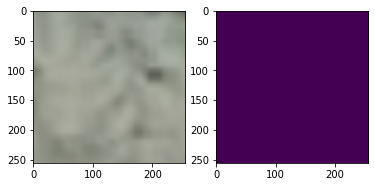

In [7]:
dataset.show_tuple(100)

# 2 Model

In [6]:
model_path = save_dir + "/" + model_name +  ".pth"
state_dict = torch.load(model_path,map_location="cpu")

In [7]:


if data_parallel:
    # create new OrderedDict that does not contain `module.`
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    model_path = save_dir + "/" + model_name +  "_new.pth"
    torch.save(new_state_dict,model_path)
    

## 2.1 Advanced Unet

In [8]:
# Change here to adapt to your data
# n_channels=3 for RGB images 
# n_classes is the number of probabilities you want to get per pixel

net = UNet(n_channels=3, n_classes=2, bilinear=False)
#net= DataParallel(net)

if data_parallel:
    net.load_state_dict(new_state_dict)
else:
    net.load_state_dict(state_dict)
#net.load_state_dict(torch.load(model_path,map_location="cpu"))


net= DataParallel(net,device_ids=[0,1])
net = net.to(device=device)



## 3 Validation

In [9]:
net.eval()
y_pred = torch.empty((len(dataset),256,256),dtype=torch.float32)
start_idx = 0

with torch.no_grad(): 
    for i,batch in enumerate(test_dl):
        x = batch["x"].to(device)
        out = net(x)#["out"]
        out = torch.argmax(out,dim=1)
        out = out.cpu()
        end_idx = start_idx + len(out)
        y_pred[start_idx:end_idx] = out
        start_idx += len(out)

In [10]:
print(model_name)
print(resampling)
dataset.evaluate(y_pred)

unet_29_07_2022_120212
{2008: 8, 2009: 8, 2010: 6, 2011: 6, 2012: 6, 2013: 6, 2014: 6, 2015: 6, 2016: 6, 2017: 2, 2018: 2}
Year 2008:          acc       iou      dice
0  0.952793  0.286308  0.379634
Year 2009:         acc       iou      dice
0  0.94662  0.479613  0.487908
Year 2010:          acc       iou      dice
0  0.900956  0.270961  0.300758
Year 2011:          acc       iou      dice
0  0.993583  0.830854  0.832667
Year 2012:          acc       iou      dice
0  0.978556  0.842831  0.845861
Year 2013:          acc       iou     dice
0  0.837919  0.375882  0.41439
Year 2014:          acc       iou      dice
0  0.975222  0.719154  0.723436
Year 2015:         acc       iou      dice
0  0.89524  0.469674  0.512272
Year 2016:          acc      iou    dice
0  0.941633  0.53803  0.5684
Year 2017:          acc       iou      dice
0  0.998286  0.896129  0.897205
Year 2018:          acc       iou      dice
0  0.935285  0.633328  0.672044
Total score:          acc       iou     dice
0  0.937

,acc,iou,dice
0,0.937661,0.602222,0.62417


# Results

In [13]:
print(model_name)
print(resampling)
dataset.evaluate(y_pred)

unet_19_07_2022_115722
{2008: 8, 2009: 8, 2010: 6, 2011: 6, 2012: 6, 2013: 6, 2014: 4, 2015: 4, 2016: 4, 2017: 2, 2018: 2}
Year 2008:          acc       iou      dice
0  0.956459  0.202087  0.214328
Year 2009:          acc       iou      dice
0  0.949152  0.509945  0.513385
Year 2010:          acc       iou      dice
0  0.942054  0.425193  0.445568
Year 2011:          acc       iou      dice
0  0.995606  0.856916  0.858888
Year 2012:         acc       iou      dice
0  0.99345  0.881949  0.881953
Year 2013:          acc       iou      dice
0  0.854746  0.395566  0.409318
Year 2014:          acc       iou      dice
0  0.991669  0.716439  0.720714
Year 2015:          acc       iou      dice
0  0.902217  0.385618  0.427653
Year 2016:          acc       iou      dice
0  0.946296  0.471404  0.514228
Year 2017:          acc       iou      dice
0  0.998246  0.891423  0.891957
Year 2018:          acc       iou      dice
0  0.936259  0.625794  0.659467
Total score:          acc       iou      di

,acc,iou,dice
0,0.946855,0.608075,0.624397


In [12]:
print(model_name)
print(resampling)
dataset.evaluate(y_pred)

unet_18_07_2022_150108
{2008: 8, 2009: 8, 2010: 6, 2011: 6, 2012: 6, 2013: 6, 2014: 4, 2015: 4, 2016: 4, 2017: 2, 2018: 2}
Year 2008:          acc       iou      dice
0  0.957331  0.290573  0.381937
Year 2009:          acc       iou      dice
0  0.947572  0.477102  0.489153
Year 2010:          acc       iou      dice
0  0.917334  0.288467  0.332361
Year 2011:         acc       iou      dice
0  0.99345  0.803195  0.810178
Year 2012:          acc       iou      dice
0  0.993028  0.892245  0.892693
Year 2013:          acc       iou      dice
0  0.848691  0.377379  0.414514
Year 2014:          acc       iou      dice
0  0.960033  0.658945  0.668113
Year 2015:          acc       iou      dice
0  0.905328  0.416016  0.486234
Year 2016:          acc       iou      dice
0  0.941419  0.468549  0.525598
Year 2017:          acc       iou      dice
0  0.998256  0.889735  0.893397
Year 2018:          acc      iou      dice
0  0.934697  0.61759  0.655713
Total score:         acc       iou      dice


,acc,iou,dice
0,0.94083,0.584479,0.613663


In [12]:
print(model_name)
print(resampling)
dataset.evaluate(y_pred)

unet_29_07_2022_120212
{2008: 8, 2009: 8, 2010: 6, 2011: 6, 2012: 6, 2013: 6, 2014: 4, 2015: 4, 2016: 4, 2017: 2, 2018: 2}
Year 2008:          acc       iou      dice
0  0.952793  0.286308  0.379634
Year 2009:         acc       iou      dice
0  0.94662  0.479613  0.487908
Year 2010:          acc       iou      dice
0  0.900956  0.270961  0.300758
Year 2011:          acc       iou      dice
0  0.993583  0.830854  0.832667
Year 2012:          acc       iou      dice
0  0.978556  0.842831  0.845861
Year 2013:          acc       iou     dice
0  0.837919  0.375882  0.41439
Year 2014:          acc       iou      dice
0  0.989671  0.680751  0.686894
Year 2015:          acc       iou      dice
0  0.889819  0.445146  0.509808
Year 2016:          acc       iou      dice
0  0.950422  0.493514  0.538708
Year 2017:          acc       iou      dice
0  0.998286  0.896129  0.897205
Year 2018:          acc       iou      dice
0  0.935285  0.633328  0.672044
Total score:          acc       iou      dice

,acc,iou,dice
0,0.939075,0.593245,0.618549


In [13]:
print(model_name)
print(resampling)
dataset.evaluate(y_pred)

unet_19_07_2022_115722
{2008: 8, 2009: 8, 2010: 6, 2011: 6, 2012: 6, 2013: 6, 2014: 6, 2015: 6, 2016: 6, 2017: 2, 2018: 2}
Year 2008:          acc       iou      dice
0  0.956459  0.202087  0.214328
Year 2009:          acc       iou      dice
0  0.949152  0.509945  0.513385
Year 2010:          acc       iou      dice
0  0.942054  0.425193  0.445568
Year 2011:          acc       iou      dice
0  0.995606  0.856916  0.858888
Year 2012:         acc       iou      dice
0  0.99345  0.881949  0.881953
Year 2013:          acc       iou      dice
0  0.854746  0.395566  0.409318
Year 2014:          acc       iou     dice
0  0.988347  0.736592  0.73929
Year 2015:          acc       iou      dice
0  0.896149  0.422556  0.439457
Year 2016:          acc      iou      dice
0  0.937132  0.52262  0.535424
Year 2017:          acc       iou      dice
0  0.998246  0.891423  0.891957
Year 2018:          acc       iou      dice
0  0.936259  0.625794  0.659467
Total score:          acc       iou      dice
0

,acc,iou,dice
0,0.945257,0.617377,0.628703


In [12]:
print(model_name)
print(resampling)
dataset.evaluate(y_pred)

unet_18_07_2022_150108
{2008: 8, 2009: 8, 2010: 6, 2011: 6, 2012: 6, 2013: 6, 2014: 6, 2015: 6, 2016: 6, 2017: 2, 2018: 2}
Year 2008:         acc       iou      dice
0  0.95733  0.290562  0.381926
Year 2009:          acc       iou      dice
0  0.947572  0.477257  0.489306
Year 2010:          acc       iou      dice
0  0.917333  0.288468  0.332361
Year 2011:         acc       iou      dice
0  0.99345  0.803194  0.810177
Year 2012:          acc       iou      dice
0  0.993028  0.892245  0.892693
Year 2013:         acc       iou      dice
0  0.84869  0.377381  0.414518
Year 2014:          acc       iou      dice
0  0.959152  0.660978  0.668311
Year 2015:          acc       iou      dice
0  0.895037  0.405684  0.433288
Year 2016:          acc       iou      dice
0  0.932975  0.492473  0.521219
Year 2017:          acc       iou      dice
0  0.998256  0.889736  0.893398
Year 2018:          acc       iou      dice
0  0.934697  0.617591  0.655715
Total score:          acc       iou      dice
0

,acc,iou,dice
0,0.939123,0.585984,0.608846
